In [1]:
from local_functions import *

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt


from numpy import s_

import warnings
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore') 

## Loading street centerline data from Alameda County public data

Data available at: https://data.acgov.org/datasets/0fa4083923be419ebafc6de8cd2426b8_0?page=10

In [2]:
centerlines = gpd.read_file(("Street_Centerlines/"))
centerlines = centerlines[centerlines.Miles != 0]

In [3]:
# add a few columns and preload them. these will be used for edge weights

centerlines = centerlines.assign(elevation = None)
centerlines = centerlines.assign(forward_weight = centerlines.Miles * 1609.34)
centerlines = centerlines.assign(reverse_weight = centerlines.Miles * 1609.34)
centerlines = centerlines.set_index('SEGID')

## Load Streets into a NetworkX graph

In [4]:
dG = nx.DiGraph()
centerlines.apply(add_edge_to_graph, 1, args = [dG])

SEGID
20201    None
20202    None
21119    None
21120    None
26368    None
         ... 
10324    None
10325    None
10326    None
11168    None
11169    None
Length: 83944, dtype: object

60TH ST
STANFORD AV
ADELINE ST
ALCATRAZ AV
CLAREMONT AV
GRIZZLY PEAK BL



GRIZZLY PEAK BL
SPRUCE ST
EUNICE ST
OXFORD ST
CENTER ST
MARTIN LUTHER KING JR WY
PARKER ST
GRANT ST
STUART ST
MC GEE AV
RUSSELL ST
CALIFORNIA ST
ASHBY AV
SACRAMENTO ST
MARKET ST
LOWELL
61ST PL
61ST ST
IDAHO ST


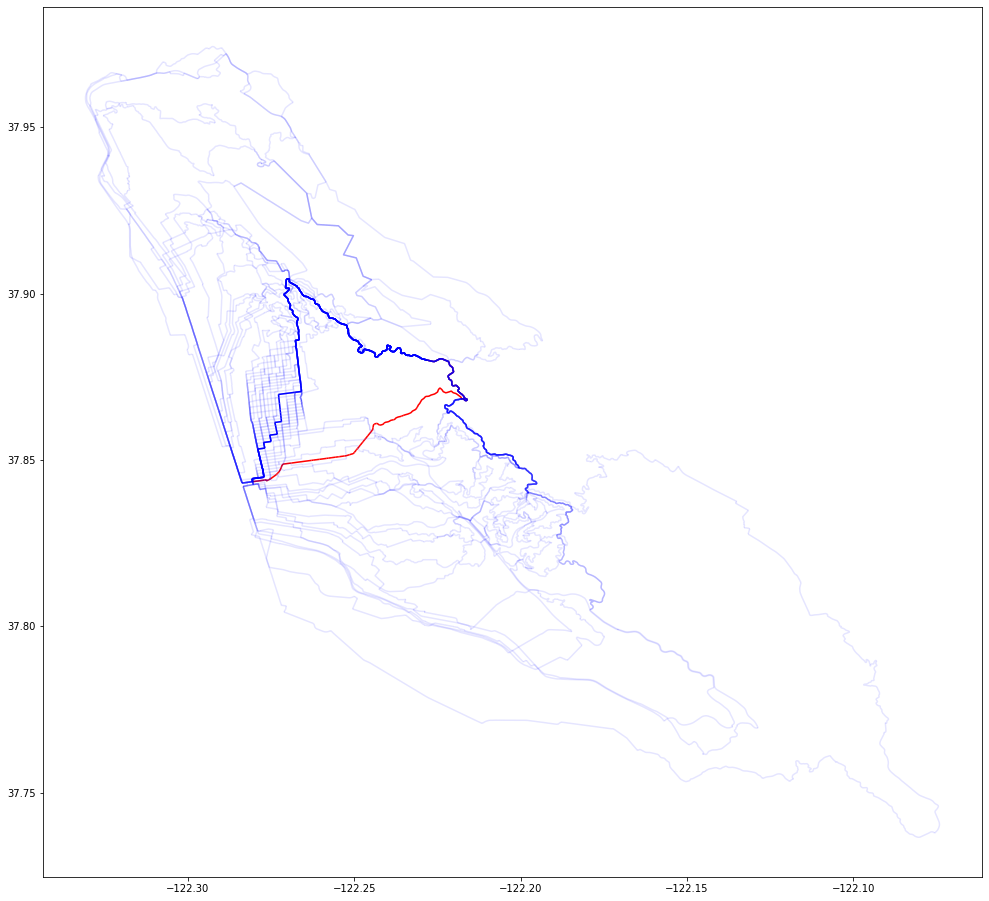

In [6]:
start = (37.843530, -122.280591)
grizzly_peak = (37.881119, -122.231569)
briones = (37.922408, -122.195821)
sibley = (37.847421, -122.199077)

fig, ax = plt.subplots(figsize = (20,16)) 
updates =1 
while updates != 0:
    path = get_path(start, grizzly_peak, dG, weight = 'weight')
    path_nodes = []
    for i in range(len(path) -1):
        path_nodes.append(dG.get_edge_data(*path[i:i+2])['id'])
    centerlines.geometry[path_nodes].plot(ax = ax, alpha=0.1, color = 'red')
    _, updates = update_costs(path, 1000, 5, centerlines, dG) 
centerlines.geometry[path_nodes].plot(ax = ax, alpha=1, color = 'red')
last_street_name = ''
for i in range(len(path) -1):
    path_nodes.append(dG.get_edge_data(*path[i:i+2])['id'])
    street_name = dG.get_edge_data(*path[i:i+2])['name']
    if (street_name != last_street_name):
        print(street_name)
        last_street_name = street_name
        
print('\n\n')
        
updates =1 
while updates != 0:
    path = get_path(grizzly_peak, start, dG, weight = 'weight')
    path_nodes = []
    for i in range(len(path) -1):
        path_nodes.append(dG.get_edge_data(*path[i:i+2])['id'])
    centerlines.geometry[path_nodes].plot(ax = ax, alpha=0.1, color = 'blue')
    _, updates = update_costs(path, 1000, 5, centerlines, dG) 
centerlines.geometry[path_nodes].plot(ax = ax, alpha=1, color = 'blue')
last_street_name = ''
for i in range(len(path) -1):
    path_nodes.append(dG.get_edge_data(*path[i:i+2])['id'])
    street_name = dG.get_edge_data(*path[i:i+2])['name']
    if (street_name != last_street_name):
        print(street_name)
        last_street_name = street_name
        
plt.show()
